<img src="../../images/logo.png" style="float:right; max-width: 120px; display: inline" alt="SizingLab" />



# Simulation models with Python

*Written by Marc Budinger (INSA Toulouse) and Scott Delbecq (ISAE-SUPAERO), Toulouse, France*

### Thermal model of an electric motor

The thermal model of a motor, **Figure n° 1**, distinguish temperature between
winding and yoke with a 2 bodies model. One can distinguish:

-   heat capacity of the winding: *Cth1*

-   heat capacity of the yoke: *Cth2*

-   the thermal resistance between the winding and the yoke (corresponding to
    the electrical insulator): *Rth1*

-   the thermal resistance between the yoke and the ambient air: *Rth2*

**Figure n° 1 –** *2 bodies thermal model of the motor*

![ThermalModel](./assets/images/thermalmodel.png)


### Modelica or state space model

A Modelica model such as **Figure 2** could be simulated in Dymola or OpenModelica.
**Figure n° 2** – *Modelica model*
![Modelica Model](./assets/images/modelicathermalmodel.png)

To simulate it in Python it is possible to use Functional Mock-up Units ([FMU](https://github.com/modelon-community/PyFMI)) which can be exported by system simulation softwares. 

Here, we propose to use a simple state-space approach using the [scipy](https://scipy.org) package.


Recall: the transfert function of the problem can be expressed as  

$Z_{th}=\frac{\theta(p)}{P(p)}=R_{th,eq}\frac{1+T_0p}{1+(T_1+T_2)p+T_1T_2p}$  
with:  
- $R_{th,eq}=R_1+R_2$
- $T_0=\frac{R_1R_2}{R_1+R_2}C_2$
- $T_1+T_2=(R_1+R_2)C_1 + R_2C_2$
- $T_1T_2=R_1C_1R_2C_2$



In [1]:
from scipy.signal import step
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def motor_temperature(P, R1, C1, R2, C2, time=np.linspace(0, 200, 100)):
    Rtheq = R1 + R2
    T0 = R1 * R2 / (R1 + R2) * C2
    T1pT2 = (R1 + R2) * C1 + R2 * C2
    T1T2 = R1 * C1 * R2 * C2
    t, y = step(system=([Rtheq * T0, Rtheq], [T1T2, T1pT2, 1]), T=time)
    theta_winding = y * P
    d = {"t": t, "theta_winding": theta_winding}
    df = pd.DataFrame(data=d)
    return df

In [2]:
# Parameters
# Losses [W]
P = 100.0
# R1 [K/W]
R1 = 0.3
# C1 [J/K]
C1 = 150.0
# R2 [K/W]
R2 = 0.3
# C2 [J/K]
C2 = 150.0
# Simulation time [s]
t_final = 150.0

time = np.linspace(0, t_final, 100)

df = motor_temperature(P, R1, C1, R2, C2, time=time)

We can now access to the simulation results and plot them:

In [3]:
df

,t,theta_winding
0,0.000000,0.000000
1,1.515152,0.993470
2,3.030303,1.955111
3,4.545455,2.886946
4,6.060606,3.790832
...,...,...
95,143.939394,43.250294
96,145.454545,43.464381
97,146.969697,43.675729
98,148.484848,43.884372


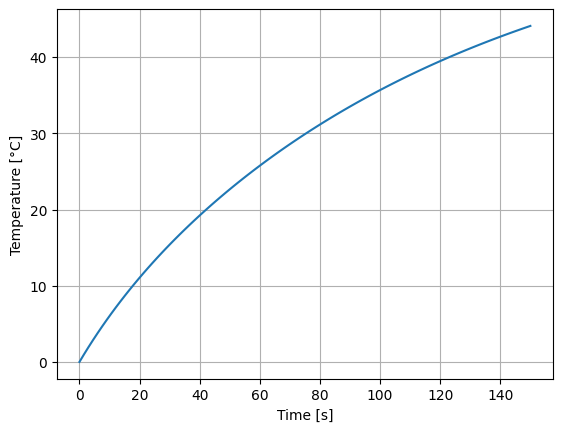

In [4]:
plt.plot(df["t"], df["theta_winding"])
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.grid()

We can access the motor final temperature:

In [5]:
print("Final temperature = %.2f °C" % df["theta_winding"].iloc[-1])

Final temperature = 44.09 °C


We can use interpolation to estimate intermediate temperatures:

In [6]:
from scipy import interpolate

theta_mot_f = interpolate.interp1d(df["t"], df["theta_winding"])

t = 100.0
theta_mot = theta_mot_f(t)

print("The temperature at t = %.2f s is %.2f °C" % (t, theta_mot))

The temperature at t = 100.00 s is 35.67 °C


## Exercise
Simulate the winding temperature for 500 s and 200 W losses:

In [7]:
time = np.linspace(0, 500, 1000)
P = 200
df = motor_temperature(P, R1, C1, R2, C2, time=time)

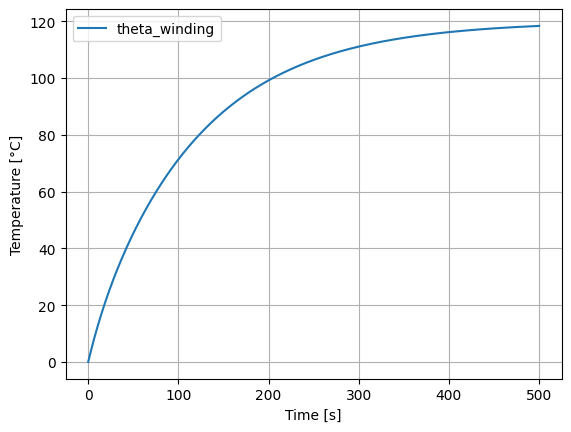

In [8]:
plt.plot(df["t"], df["theta_winding"])
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.grid()
plt.legend(["theta_winding", "theta_core"], loc="upper left")